In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

2023-12-12 19:04:31.915074: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 19:04:32.108188: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 19:04:32.109409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 19:04:33.823802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


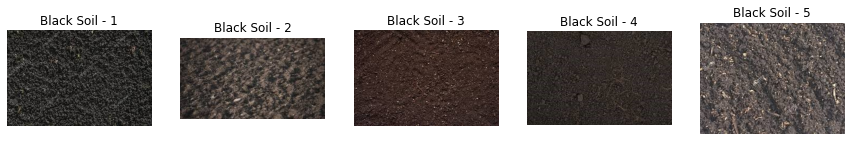

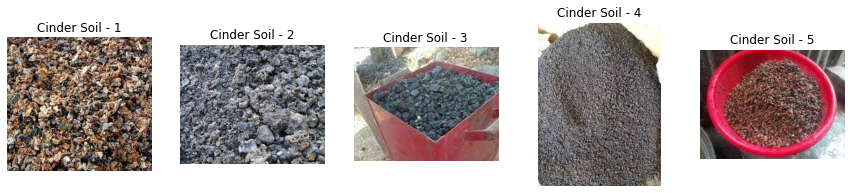

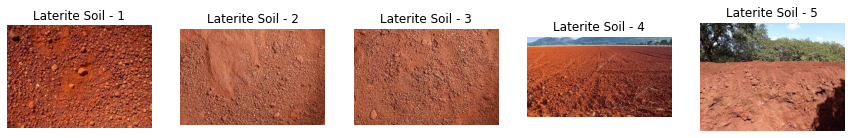

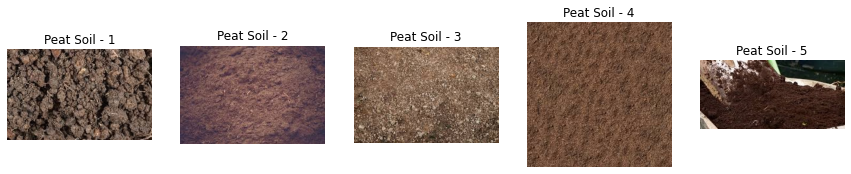

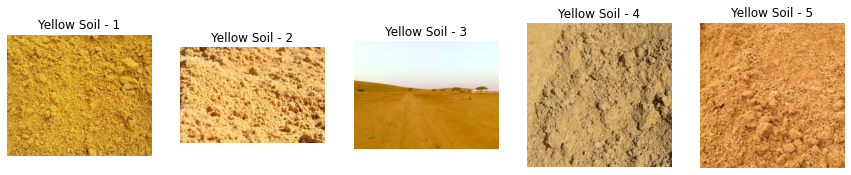

In [2]:
# Directories for the dataset used
dir_black = '/home/soukaina/Downloads/Soil types/Black Soil'
dir_Cinder = '/home/soukaina/Downloads/Soil types/Cinder Soil'
dir_Laterite = '/home/soukaina/Downloads/Soil types/Laterite Soil'
dir_peat = '/home/soukaina/Downloads/Soil types/Peat Soil'
dir_yellow = '/home/soukaina/Downloads/Soil types/Yellow Soil'

# Function to load and display sample images
def display_sample_images(directory, label):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # Adjust the number of images to display
    
    for i, file in enumerate(os.listdir(directory)[:5]):  # Load and display the first 5 images
        img_path = os.path.join(directory, file)
        img = cv2.imread(img_path)
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
        axs[i].set_title(f'{label} - {i+1}')
        axs[i].axis('off')
    plt.show()

# Display sample images from each soil type directory
display_sample_images(dir_black, 'Black Soil')
display_sample_images(dir_Cinder, 'Cinder Soil')
display_sample_images(dir_Laterite, 'Laterite Soil')
display_sample_images(dir_peat, 'Peat Soil')
display_sample_images(dir_yellow, 'Yellow Soil')

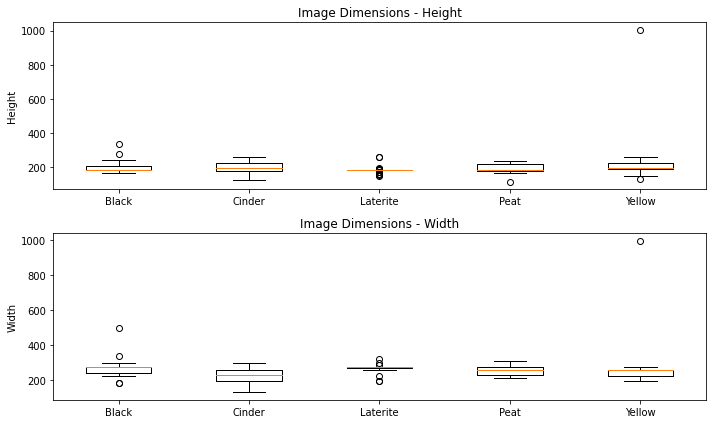

In [3]:
# Function to analyze image dimensions and detect inconsistencies
def analyze_image_dimensions(directory):
    image_dimensions = []
    for file in os.listdir(directory):
        img_path = os.path.join(directory, file)
        img = cv2.imread(img_path)
        height, width, channels = img.shape
        image_dimensions.append((height, width))
    
    return image_dimensions

# Analyze image dimensions for each soil type
black_dimensions = analyze_image_dimensions(dir_black)
cinder_dimensions = analyze_image_dimensions(dir_Cinder)
laterite_dimensions = analyze_image_dimensions(dir_Laterite)
peat_dimensions = analyze_image_dimensions(dir_peat)
yellow_dimensions = analyze_image_dimensions(dir_yellow)

# Visualize image dimensions for each soil type
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.title('Image Dimensions - Height')
plt.boxplot([h for h, _ in black_dimensions], positions=[1], widths=0.5, labels=['Black'])
plt.boxplot([h for h, _ in cinder_dimensions], positions=[2], widths=0.5, labels=['Cinder'])
plt.boxplot([h for h, _ in laterite_dimensions], positions=[3], widths=0.5, labels=['Laterite'])
plt.boxplot([h for h, _ in peat_dimensions], positions=[4], widths=0.5, labels=['Peat'])
plt.boxplot([h for h, _ in yellow_dimensions], positions=[5], widths=0.5, labels=['Yellow'])
plt.ylabel('Height')

plt.subplot(2, 1, 2)
plt.title('Image Dimensions - Width')
plt.boxplot([w for _, w in black_dimensions], positions=[1], widths=0.5, labels=['Black'])
plt.boxplot([w for _, w in cinder_dimensions], positions=[2], widths=0.5, labels=['Cinder'])
plt.boxplot([w for _, w in laterite_dimensions], positions=[3], widths=0.5, labels=['Laterite'])
plt.boxplot([w for _, w in peat_dimensions], positions=[4], widths=0.5, labels=['Peat'])
plt.boxplot([w for _, w in yellow_dimensions], positions=[5], widths=0.5, labels=['Yellow'])
plt.ylabel('Width')

plt.tight_layout()
plt.show()


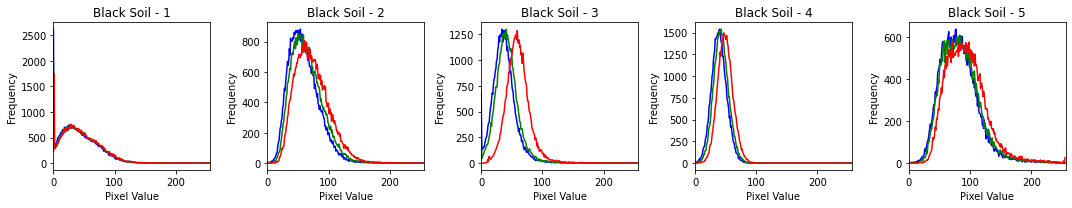

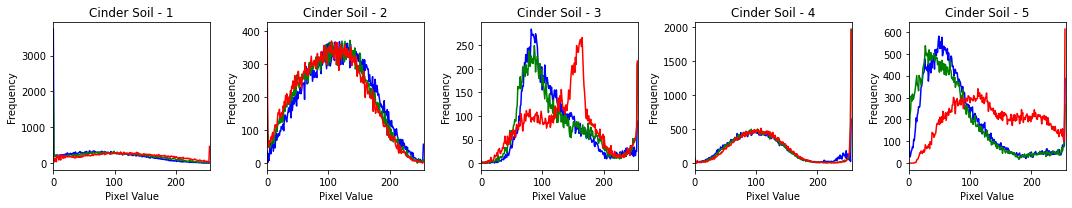

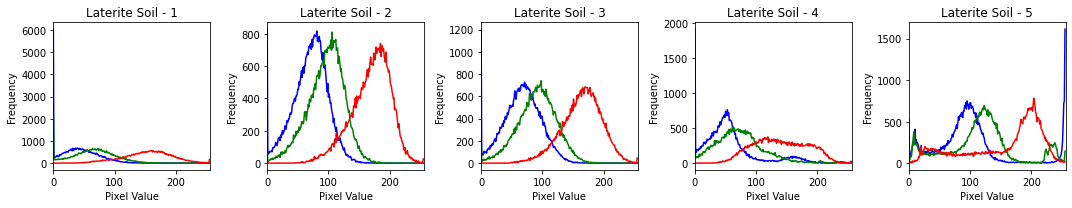

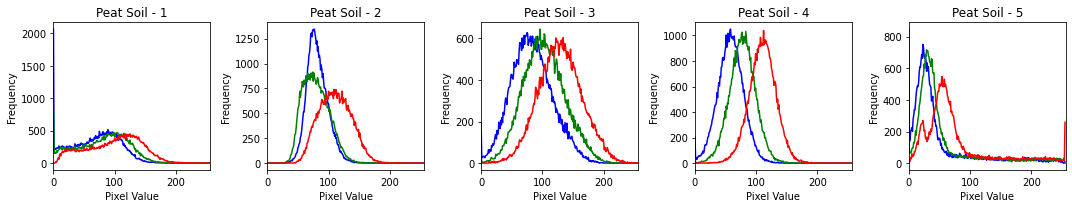

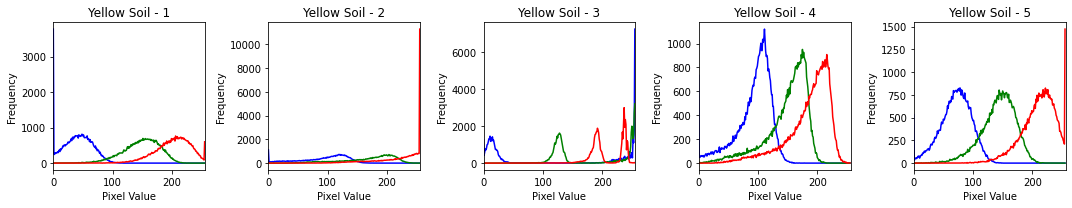

In [4]:
# Function to plot color histograms for sample images
def plot_color_histograms(directory, label):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # Adjust the number of images to display
    
    for i, file in enumerate(os.listdir(directory)[:5]):  # Load and display histograms for the first 5 images
        img_path = os.path.join(directory, file)
        img = cv2.imread(img_path)
        
        color = ('b', 'g', 'r')
        for j, col in enumerate(color):
            histr = cv2.calcHist([img], [j], None, [256], [0, 256])
            axs[i].plot(histr, color=col)
            axs[i].set_xlim([0, 256])
        
        axs[i].set_title(f'{label} - {i+1}')
        axs[i].set_xlabel('Pixel Value')
        axs[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plot color histograms for sample images from each soil type directory
plot_color_histograms(dir_black, 'Black Soil')
plot_color_histograms(dir_Cinder, 'Cinder Soil')
plot_color_histograms(dir_Laterite, 'Laterite Soil')
plot_color_histograms(dir_peat, 'Peat Soil')
plot_color_histograms(dir_yellow, 'Yellow Soil')


In [5]:
# Define parameters
image_size = 220
batch_size = 10
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

# Image data generator with augmentation
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
)

# Flow training and validation images in batches using the generator
train_generator = train_datagen.flow_from_directory(
    '/home/soukaina/Downloads/Soil types/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    classes=['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil'],
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/home/soukaina/Downloads/Soil types/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    classes=['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil'],
    class_mode='categorical',
    subset='validation'
)


Found 126 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


In [6]:
# Define a more optimized model
model = tf.keras.models.Sequential([
    
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(220, 220, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(5, activation='softmax')
])

# Optimizer with adjusted learning rate
optimizer = RMSprop(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

# Train the model with augmented data
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    verbose=1
)

2023-12-12 19:04:46.550878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 19:04:46.552112: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/30
12/12 [==============================] - 6s 372ms/step - loss: 1.6376 - acc: 0.1810 - val_loss: 1.5786 - val_acc: 0.2000
Epoch 2/30
12/12 [==============================] - 4s 330ms/step - loss: 1.6305 - acc: 0.2845 - val_loss: 1.1378 - val_acc: 0.3667
Epoch 3/30
12/12 [==============================] - 4s 326ms/step - loss: 1.2751 - acc: 0.3793 - val_loss: 1.1209 - val_acc: 0.4333
Epoch 4/30
12/12 [==============================] - 4s 330ms/step - loss: 1.1684 - acc: 0.3621 - val_loss: 1.0573 - val_acc: 0.4667
Epoch 5/30
12/12 [==============================] - 4s 330ms/step - loss: 1.1436 - acc: 0.4310 - val_loss: 1.0038 - val_acc: 0.4000
Epoch 6/30
12/12 [==============================] - 4s 328ms/step - loss: 1.0564 - acc: 0.4138 - val_loss: 1.0002 - val_acc: 0.4667
Epoch 7/30
12/12 [==============================] - 4s 324ms/step - loss: 1.2050 - acc: 0.4741 - val_loss: 1.0437 - val_acc: 0.4000
Epoch 8/30
12/12 [==============================] - 4s 340ms/step - loss: 0.

3/3 [==============================] - 1s 207ms/step


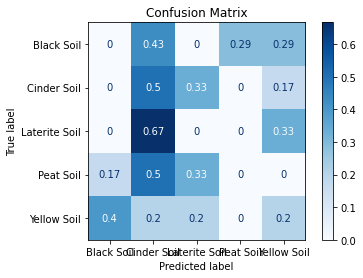

In [7]:
# Calculate predictions for test set
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, normalize='true')
labels = ['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


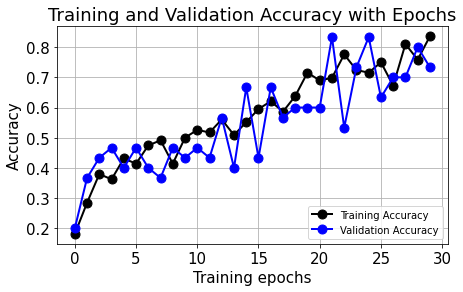

In [8]:
# Plot training and validation accuracy
plt.figure(figsize=(7, 4))
plt.plot(history.history['acc'], '-o', c='k', lw=2, markersize=9)
plt.plot(history.history['val_acc'], '-o', c='b', lw=2, markersize=9)
plt.title("Training and Validation Accuracy with Epochs", fontsize=18)
plt.xlabel("Training epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [9]:
model.save('my_model.h5')

/home/soukaina/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
